In [148]:
import numpy as np
import nltk
import pandas as pd

In [149]:
#導入資料集
train_path = "train.txt"
test_path = "test.txt"
def getData(path):
    text = []
    label = []
    with open(path) as f:
        for i in f.readlines():
            rows = i.split(";")
            text.append(rows[0])
            label.append(rows[1])
    return text,label
train_text, train_label = getData(train_path)
test_text, test_label = getData(test_path)

df = pd.DataFrame(zip(train_text, train_label),columns=["sentence","label"])


['im feeling rather rotten so im not very ambitious right now',
 'im updating my blog because i feel shitty',
 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her',
 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived',
 'i was feeling a little vain when i did this one',
 'i cant walk into a shop anywhere where i do not feel uncomfortable',
 'i felt anger when at the end of a telephone call',
 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia',
 'i like to have the same breathless feeling as a reader eager to see what will happen next',
 'i jest i feel grumpy tired and pre menstrual which i probably am but then again its only been a week and im about as fit as a walrus on vacation for the summer',
 'i don t

In [150]:
#空值檢查
print(df.shape)
print(df.isnull().sum())

(16000, 2)
sentence    0
label       0
dtype: int64


In [151]:
#資料前處理
import re
import string

def remove_hyperlinks(text):
    sentence = re.sub(r"http","",text)
    sentence = re.sub(r"www","",sentence)
    return sentence

def remove_punctuation(text):
    return ''.join([word for word in text if word not in string.punctuation])
def reshape(text):
    sentence = re.sub(r"\n","",text)
    return sentence

df['sentence'] = df['sentence'].apply(lambda x: remove_hyperlinks(x.lower()))
df['label'] = df['label'].apply(lambda x: reshape(x))


,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [152]:
#分詞
def tokenize(text):
    return text.split(" ")

df['sentence'] = df['sentence'].apply(lambda x: remove_punctuation(x))
df['sentence'] = df['sentence'].apply(lambda x: tokenize(x))


,sentence,label
0,"[i, didnt, feel, humiliated]",sadness
1,"[i, can, go, from, feeling, so, hopeless, to, ...",sadness
2,"[im, grabbing, a, minute, to, post, i, feel, g...",anger
3,"[i, am, ever, feeling, nostalgic, about, the, ...",love
4,"[i, am, feeling, grouchy]",anger
5,"[ive, been, feeling, a, little, burdened, late...",sadness
6,"[ive, been, taking, or, milligrams, or, times,...",surprise
7,"[i, feel, as, confused, about, life, as, a, te...",fear
8,"[i, have, been, with, petronas, for, years, i,...",joy
9,"[i, feel, romantic, too]",love


In [153]:
#移除停用詞
from nltk.corpus import stopwords

stopword = stopwords.words('english')
def remove_stopword(text):
    return [word for word in text if word not in stopword]

df['sentence'] = df['sentence'].apply(lambda x: remove_stopword(x))


,sentence,label
0,"[didnt, feel, humiliated]",sadness
1,"[go, feeling, hopeless, damned, hopeful, aroun...",sadness
2,"[im, grabbing, minute, post, feel, greedy, wrong]",anger
3,"[ever, feeling, nostalgic, fireplace, know, st...",love
4,"[feeling, grouchy]",anger
5,"[ive, feeling, little, burdened, lately, wasnt...",sadness
6,"[ive, taking, milligrams, times, recommended, ...",surprise
7,"[feel, confused, life, teenager, jaded, year, ...",fear
8,"[petronas, years, feel, petronas, performed, w...",joy
9,"[feel, romantic]",love


In [154]:
#還原詞性
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text])

df['sentence'] = df['sentence'].apply(lambda x: lemmatize(x))


,sentence,label
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
5,ive feeling little burdened lately wasnt sure,sadness
6,ive taking milligram time recommended amount i...,surprise
7,feel confused life teenager jaded year old man,fear
8,petronas year feel petronas performed well mad...,joy
9,feel romantic,love


In [155]:
#取得label列表
category = df["label"].unique().tolist()

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [156]:
#取得text列表，並將dataframe中label的值轉為label列表中對應的index
sentence = df['sentence'].values
label = df["label"].apply(lambda x: category.index(x)).values


In [157]:
#取得所有不重複的詞彙
words = [word.lower() for s in sentence for word in s.split(" ")]
various_words = list(set(words))

In [158]:
#建立字典索引，並交換key和value
int2word = dict(enumerate(various_words))
word2int = {w:int(i) for i,w in int2word.items()}

In [159]:
#計算每個text中詞彙的個數
from collections import Counter
sentence_length = [len(s.split()) for s in sentence]
counts = dict(Counter(sentence_length))

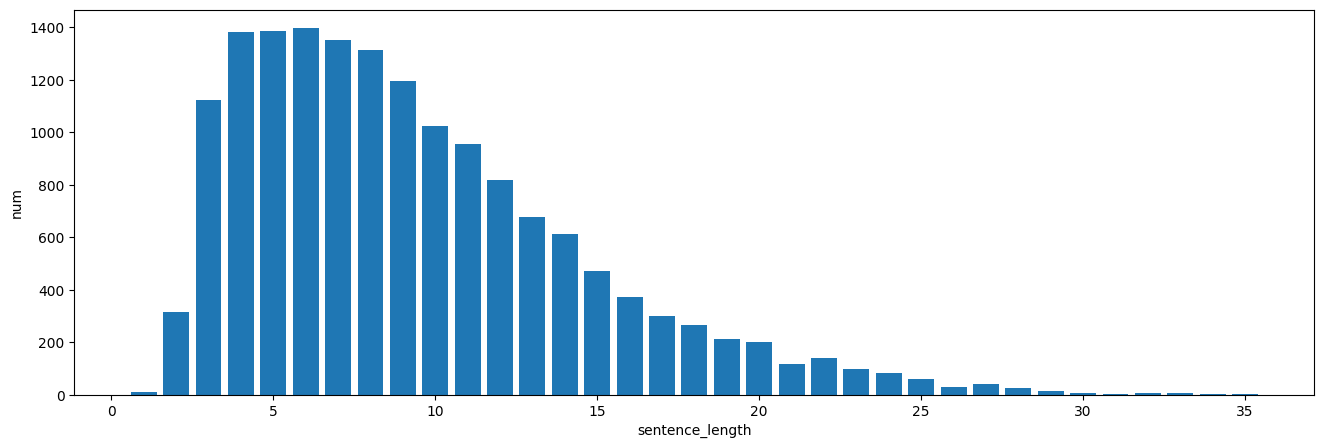

In [160]:
#繪製詞彙長度分布圖
import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
plt.bar(counts.keys(),counts.values())
plt.xlabel("sentence_length")
plt.ylabel("num")
plt.show()


In [161]:
#取得上下界限值的值及它的個數
min_sen = min(counts.items())
max_sen = max(counts.items())

((1, 8), (35, 2))

In [162]:
#取得詞彙長度等於上下限的值之index
min_index = [i for i,length in enumerate(sentence_length) if length==min_sen[0]]
max_index = [i for i,length in enumerate(sentence_length) if length==max_sen[0]]


In [163]:
#刪除最小值和最大值的文本
new_text = np.delete(sentence, min_index)
new_text2 = np.delete(new_text, max_index)


array(['didnt feel humiliated',
       'go feeling hopeless damned hopeful around someone care awake',
       'im grabbing minute post feel greedy wrong', ...,
       'feel strong good overall', 'feel like rude comment im glad',
       'know lot feel stupid portray'], dtype=object)

In [164]:
#刪除最大和最小值的標籤
new_labels = np.delete(label, min_index)
new_labels = np.delete(new_labels, max_index)


array([0, 0, 1, ..., 5, 1, 0], dtype=int64)

In [165]:
#利用建立好的字典將詞彙token轉為數字
text2ints = []
for sentence in new_text2:
    sample = list()
    for word in sentence.split():
        int_value = word2int[word]
        sample.append(int_value)
    text2ints.append(sample)
text2ints[:5]



[[9035, 8837, 6513],
 [8063, 13413, 9710, 9299, 6891, 1275, 5100, 3236, 4337],
 [5401, 2451, 5514, 7211, 8837, 8650, 7058],
 [5608, 13413, 4751, 6447, 6013, 5658, 5863],
 [13413, 10112]]

In [166]:
#將每一個句子padding到同樣的長度，過長的句子截斷
def reset_text(text, seq_len):
    dataset = np.zeros((len(text),seq_len))
    for index,sentence in enumerate(text):
        if len(sentence) < seq_len:
            dataset[index, :len(sentence)] = sentence
        else:
            dataset[index, :] = sentence[:seq_len]
    return dataset
            
dataset = reset_text(text2ints, seq_len=22)


array([[ 9035.,  8837.,  6513., ...,     0.,     0.,     0.],
       [ 8063., 13413.,  9710., ...,     0.,     0.,     0.],
       [ 5401.,  2451.,  5514., ...,     0.,     0.,     0.],
       ...,
       [ 8837.,  4779.,  9863., ...,     0.,     0.,     0.],
       [ 8837., 10752.,  5398., ...,     0.,     0.,     0.],
       [ 6013.,  8327.,  8837., ...,     0.,     0.,     0.]])

In [167]:
#把numpy矩陣轉為tensor張量
import torch
import torch.nn as nn
dataset_tensor = torch.from_numpy(dataset)
label_tensor = torch.from_numpy(new_labels)
print(type(dataset_tensor), type(label_tensor))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [168]:
#設定訓練和驗證資料集的比例
all_samples = len(dataset_tensor)
train_ratio = 0.8
val_ratio = 0.2

In [169]:
#從原始資料集中根據比例建立訓練資料集和驗證資料集
train = dataset_tensor[:int(train_ratio*all_samples)]
train_labels = label_tensor[:int(train_ratio*all_samples)]

val = dataset_tensor[int(train_ratio*all_samples):]
val_labels = label_tensor[int(train_ratio*all_samples):]




In [170]:
#將文本和標籤打包成一個Dataset，並分別建立Dataloader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train, train_labels)
val_dataset = TensorDataset(val, val_labels)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)


tensor([[13413.,  2693.,  3391.,  ...,     0.,     0.,     0.],
        [ 7791.,  6274.,  8685.,  ...,     0.,     0.,     0.],
        [11432., 12304.,  3576.,  ...,     0.,     0.,     0.],
        ...,
        [ 8837., 10752.,  5401.,  ...,     0.,     0.,     0.],
        [ 8837.,  1178.,  1238.,  ...,     0.,     0.,     0.],
        [ 8837., 13071.,     0.,  ...,     0.,     0.,     0.]],
       dtype=torch.float64) tensor([0, 0, 3, 5, 0, 5, 2, 1, 3, 5, 5, 3, 0, 0, 1, 5, 5, 1, 5, 1, 5, 5, 0, 4,
        0, 0, 5, 0, 1, 1, 0, 3, 5, 4, 5, 5, 5, 4, 5, 5, 2, 5, 3, 1, 3, 4, 1, 1,
        0, 4, 5, 5, 0, 1, 5, 4, 5, 4, 0, 5, 0, 4, 4, 1, 0, 0, 0, 0, 2, 0, 4, 2,
        5, 5, 2, 5, 2, 0, 0, 5, 4, 3, 5, 0, 5, 0, 5, 2, 5, 3, 5, 1, 0, 1, 2, 5,
        5, 5, 5, 5, 5, 4, 0, 0, 5, 1, 1, 0, 0, 0, 5, 5, 2, 5, 5, 5, 5, 0, 4, 1,
        0, 5, 1, 2, 4, 2, 3, 5])
tensor([[ 6013.,  8837.,  9926.,  ...,     0.,     0.,     0.],
        [12860., 11298.,  8837.,  ...,     0.,     0.,     0.],
        [ 883

In [171]:
#若cuda能夠使用則使用gpu訓練，否則使用cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [172]:
#建立模型
class SentimentNet(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim, output_size, num_layers, dropout=0.5):
        super(SentimentNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.embedding= nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout,batch_first=True)
        self.linear = nn.Linear(hidden_dim, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, output_size)
        
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x, hidden):      
        batch_size = x.size(0)
        x = x.long() 
        embeds = self.embedding(x) # embeds(128,10,200)
        
        
        out,hidden = self.lstm(embeds, hidden) 
        out = self.linear(out[:, -1, :]) # out(128，128)
        out = self.dropout(out)
        out = self.relu(out) 
        out = self.linear2(out) # out(128, 6)
        
        return out, hidden
    
    #初始化隱藏層
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        # h_0, c_0
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_dim),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_dim))


In [173]:
#定義參數
input_size = len(word2int)
output_size = len(category)
print(output_size)
embedding_dim = 200
hidden_dim= 128
num_layers= 2   

6


In [174]:
#建立model
model = SentimentNet(input_size, embedding_dim, hidden_dim, output_size, num_layers)
model.to(device)

SentimentNet(
  (embedding): Embedding(13476, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [175]:
#定義loss function、optimizer和scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [176]:
#建立訓練和驗證function
def train(model, data_loader, criterion, optimizer, scheduler, num_epochs):
    train_process = dict()
    train_loss_epoch10, val_loss_epoch10= [],[]
    val_acc_epoch10 = []
    for epoch in range(num_epochs):
        hs = model.init_hidden(batch_size)
        train_loss = []
        train_correct = 0
        model.train()
        for data, target in data_loader:  
            data = data.to(device)
            target = target.to(device)
            output,hs = model(data, hs)
            preds = torch.argmax(output, dim=1)
            train_correct += torch.sum(preds==target)
            
            hs = tuple([h.data for h in hs])
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        print(f"Epoch [{epoch}/{num_epochs-1}]---train loss {np.mean(train_loss):>.5f}")
        
        scheduler.step()
        
        if epoch % 10 == 0:
            validation_loss, validation_acc = validation(model, val_loader, criterion)
            
            train_loss_epoch10.append(np.mean(train_loss))
            val_loss_epoch10.append(validation_loss)
            val_acc_epoch10.append(validation_acc)
    
    train_process["train_loss"] = train_loss_epoch10
    train_process["val_loss"] = val_loss_epoch10
    train_process["val_acc"] = val_acc_epoch10
    return train_process
            
def validation(model, val_loader, criterion):
    model.eval()
    hs = model.init_hidden(batch_size)
    val_loss = []
    val_correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            outs,hs = model(data,hs)
            hs = tuple([h.data for h in hs])
        
            loss = criterion(outs, target)
            preds = torch.argmax(outs, dim=1)
            val_loss.append(loss.item())
            val_correct += torch.sum(preds==target)
    print(f"--------------------------------validation loss is: {np.mean(val_loss):>.5f}, acc is: {100*val_correct/len(val_loader.dataset):>.2f}%")
    return np.mean(val_loss), val_correct/len(val_loader.dataset)


In [177]:
#開始訓練
train_process = train(model, train_loader, criterion, optimizer,exp_lr_scheduler, num_epochs=100)

Epoch [0/99]---train loss 1.60663
--------------------------------validation loss is: 1.57486, acc is: 31.61%
Epoch [1/99]---train loss 1.59060
Epoch [2/99]---train loss 1.58762
Epoch [3/99]---train loss 1.58503
Epoch [4/99]---train loss 1.58328
Epoch [5/99]---train loss 1.58526
Epoch [6/99]---train loss 1.58344
Epoch [7/99]---train loss 1.57951
Epoch [8/99]---train loss 1.57752
Epoch [9/99]---train loss 1.55976
Epoch [10/99]---train loss 1.53905
--------------------------------validation loss is: 1.55494, acc is: 31.43%
Epoch [11/99]---train loss 1.53496
Epoch [12/99]---train loss 1.52919
Epoch [13/99]---train loss 1.52788
Epoch [14/99]---train loss 1.52123
Epoch [15/99]---train loss 1.52070
Epoch [16/99]---train loss 1.52092
Epoch [17/99]---train loss 1.51337
Epoch [18/99]---train loss 1.51005


KeyboardInterrupt: 

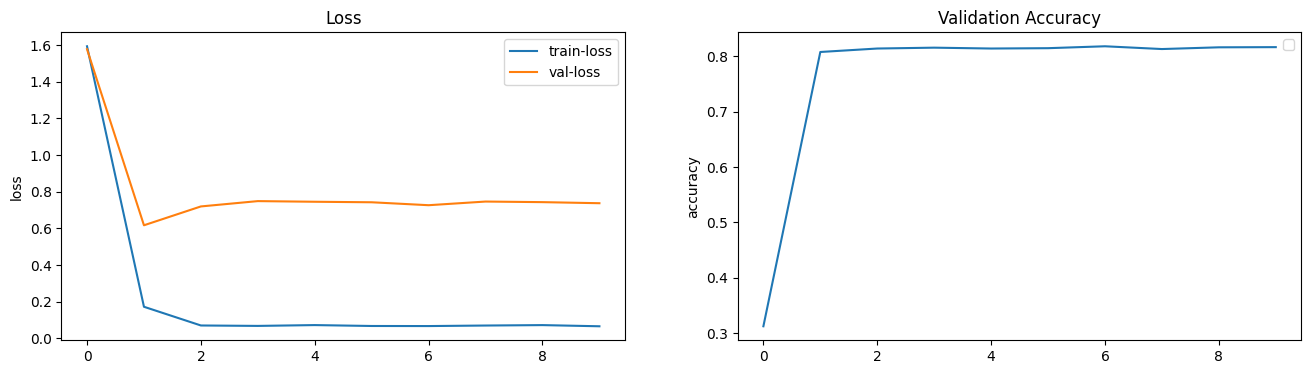

In [ ]:
#繪製loss曲線和驗證準確度
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Loss")
plt.ylabel("loss")
plt.plot(train_process["train_loss"],label="train-loss")
plt.plot(train_process["val_loss"],label="val-loss")
plt.legend()

plt.subplot(1,2,2)
plt.legend(labels=[""])
plt.ylabel("accuracy")
plt.title("Validation Accuracy")
val_acc_cpu = [acc.cpu().numpy() for acc in train_process["val_acc"]]
plt.plot(val_acc_cpu)
plt.show()


In [ ]:
#使用測試資料集預測
preds_label = []
def converts(text):
    text = remove_hyperlinks(text)
    new_text = remove_punctuation(text)
    test_text_ints = [word2int[word.lower()]for word in new_text.split() if word in word2int.keys()]
    return test_text_ints
def predict(model):
    correct = 0
    test_text_int = [converts(text) for text in test_text]

    new_test_text_int = reset_text(test_text_int, seq_len=22)
    text_tensor = torch.from_numpy(new_test_text_int)

    batch_size = text_tensor.size(0)
    hs = model.init_hidden(batch_size)
    
    text_tensor = text_tensor.to(device)
    outs, hs = model(text_tensor, hs)
    preds = torch.argmax(outs, dim=1)

    for i in range(len(test_text)):
      print(test_text[i])
      print(" prediction: ", category[int(preds[i])])
      preds_label.append(category[int(preds[i])])
    for i in range(len(preds_label)):
      test_label[i] = reshape(test_label[i])
      if preds_label[i] == test_label[i]:
          correct+=1
    
    print(" test acc: ", (correct / len(preds_label)))



predict(model)


    
    

im feeling rather rotten so im not very ambitious right now
 prediction:  sadness
im updating my blog because i feel shitty
 prediction:  sadness
i never make her separate from me because i don t ever want her to feel like i m ashamed with her
 prediction:  sadness
i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
 prediction:  joy
i was feeling a little vain when i did this one
 prediction:  sadness
i cant walk into a shop anywhere where i do not feel uncomfortable
 prediction:  fear
i felt anger when at the end of a telephone call
 prediction:  joy
i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia
 prediction:  joy
i like to have the same breathless feeling as a reader eager to see what will happen next
 prediction:  love
i jest i feel grumpy tired an